In [33]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%autosave 20

Autosaving every 20 seconds


In [34]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,ParameterGrid

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from tqdm.notebook import tqdm

### Reading the data

In [37]:
df = pd.read_csv("Truck_price_prediction.csv")
df.head()
df_backup = df.copy() # Deep Copy

Trip_Distance_km Starting_Day Day_of_Week  Palette_Count Load_Count  \
0             193.5      Morning     Weekday            3.0        Low   
1             475.9    Afternoon     Weekday            1.0       High   
2             368.7      Evening     Weekend            1.0       High   
3             303.3      Evening     Weekday            4.0        Low   
4               NaN      Evening     Weekday            3.0       High   

  Weather  Base_Fare  Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  \
0   Clear       35.6         0.80             0.32                  538.2   
1   Clear        NaN         0.62             0.43                  405.7   
2   Clear       27.0         1.21             0.15                  372.7   
3     NaN       34.8         0.51             0.15                 1168.1   
4   Clear       29.3         0.63             0.32                  226.4   

   Trip_Price  
0     362.624  
1         NaN  
2     529.032  
3     364.698  
4     156.180

### Lets Get some Idea about our Data

In [38]:
df.shape

(1000, 11)

In [39]:
df.isna().sum()
# I could see Lot of missing data points . May be These are data problem . For all Columns I coud see 50 Values missing

print(f"Only {50/1000}% data points are null ")

Trip_Distance_km         50
Starting_Day             50
Day_of_Week              50
Palette_Count            50
Load_Count               50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

Only 0.05% data points are null 


In [40]:
df.info()
#WE have mix of Floats and Objects . Our target column is Float i.e Trip Price

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Starting_Day           950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Palette_Count          950 non-null    float64
 4   Load_Count             950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [41]:
df.describe().T

count        mean         std     min       25%  \
Trip_Distance_km       950.0  270.705469  199.052998  12.300  126.3250   
Palette_Count          950.0    2.476842    1.102249   1.000    1.2500   
Base_Fare              950.0   35.029895    8.701619  20.100   27.3000   
Per_Km_Rate            950.0    1.233316    0.429816   0.500    0.8600   
Per_Minute_Rate        950.0    0.292916    0.115592   0.100    0.1900   
Trip_Duration_Minutes  950.0  621.181158  321.544065  50.100  358.8250   
Trip_Price             951.0  568.747733  404.697906  61.269  337.4265   

                           50%       75%          max  
Trip_Distance_km       258.300  384.0500  1460.670472  
Palette_Count            2.000    3.0000     4.000000  
Base_Fare               35.200   42.6000    50.000000  
Per_Km_Rate              1.220    1.6100     2.000000  
Per_Minute_Rate          0.290    0.3900     0.500000  
Trip_Duration_Minutes  618.600  890.5500  1198.400000  
Trip_Price             500.745  690.9935  3320.436887

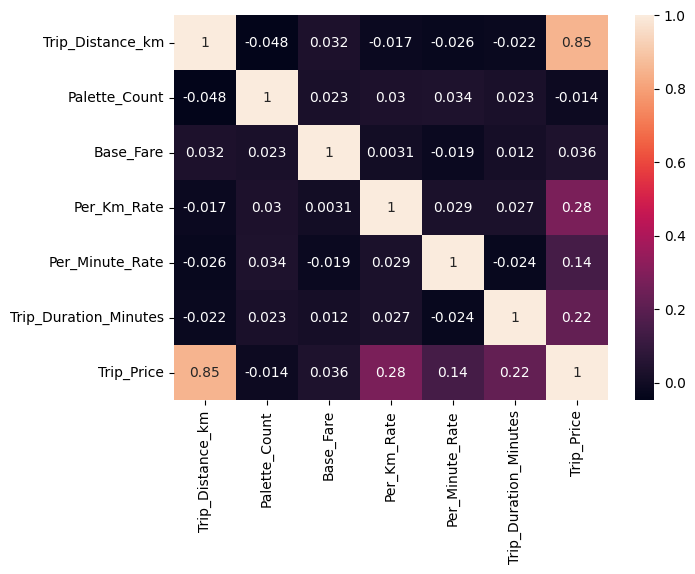

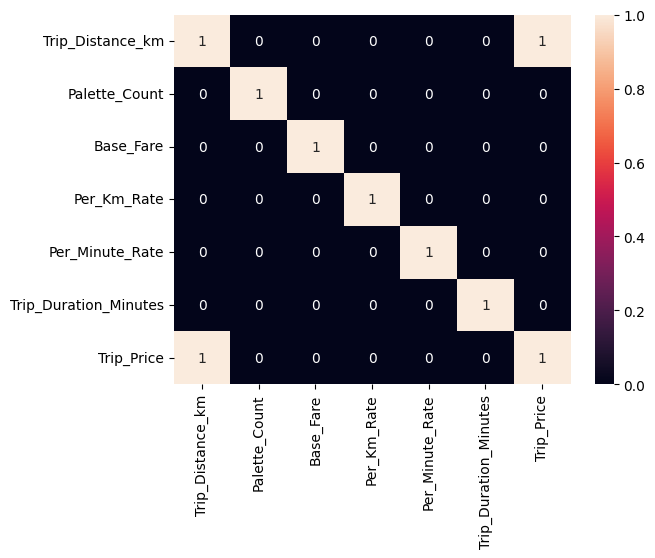

In [42]:
_ = plt.subplots(figsize= (7,5)) 
cor = df[['Trip_Distance_km', 'Palette_Count', 'Base_Fare', 'Per_Km_Rate','Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']].corr()
_ = sns.heatmap(cor,annot = True)
_= plt.show()
_ = sns.heatmap(cor.abs() > .5,annot = True)
_= plt.show()

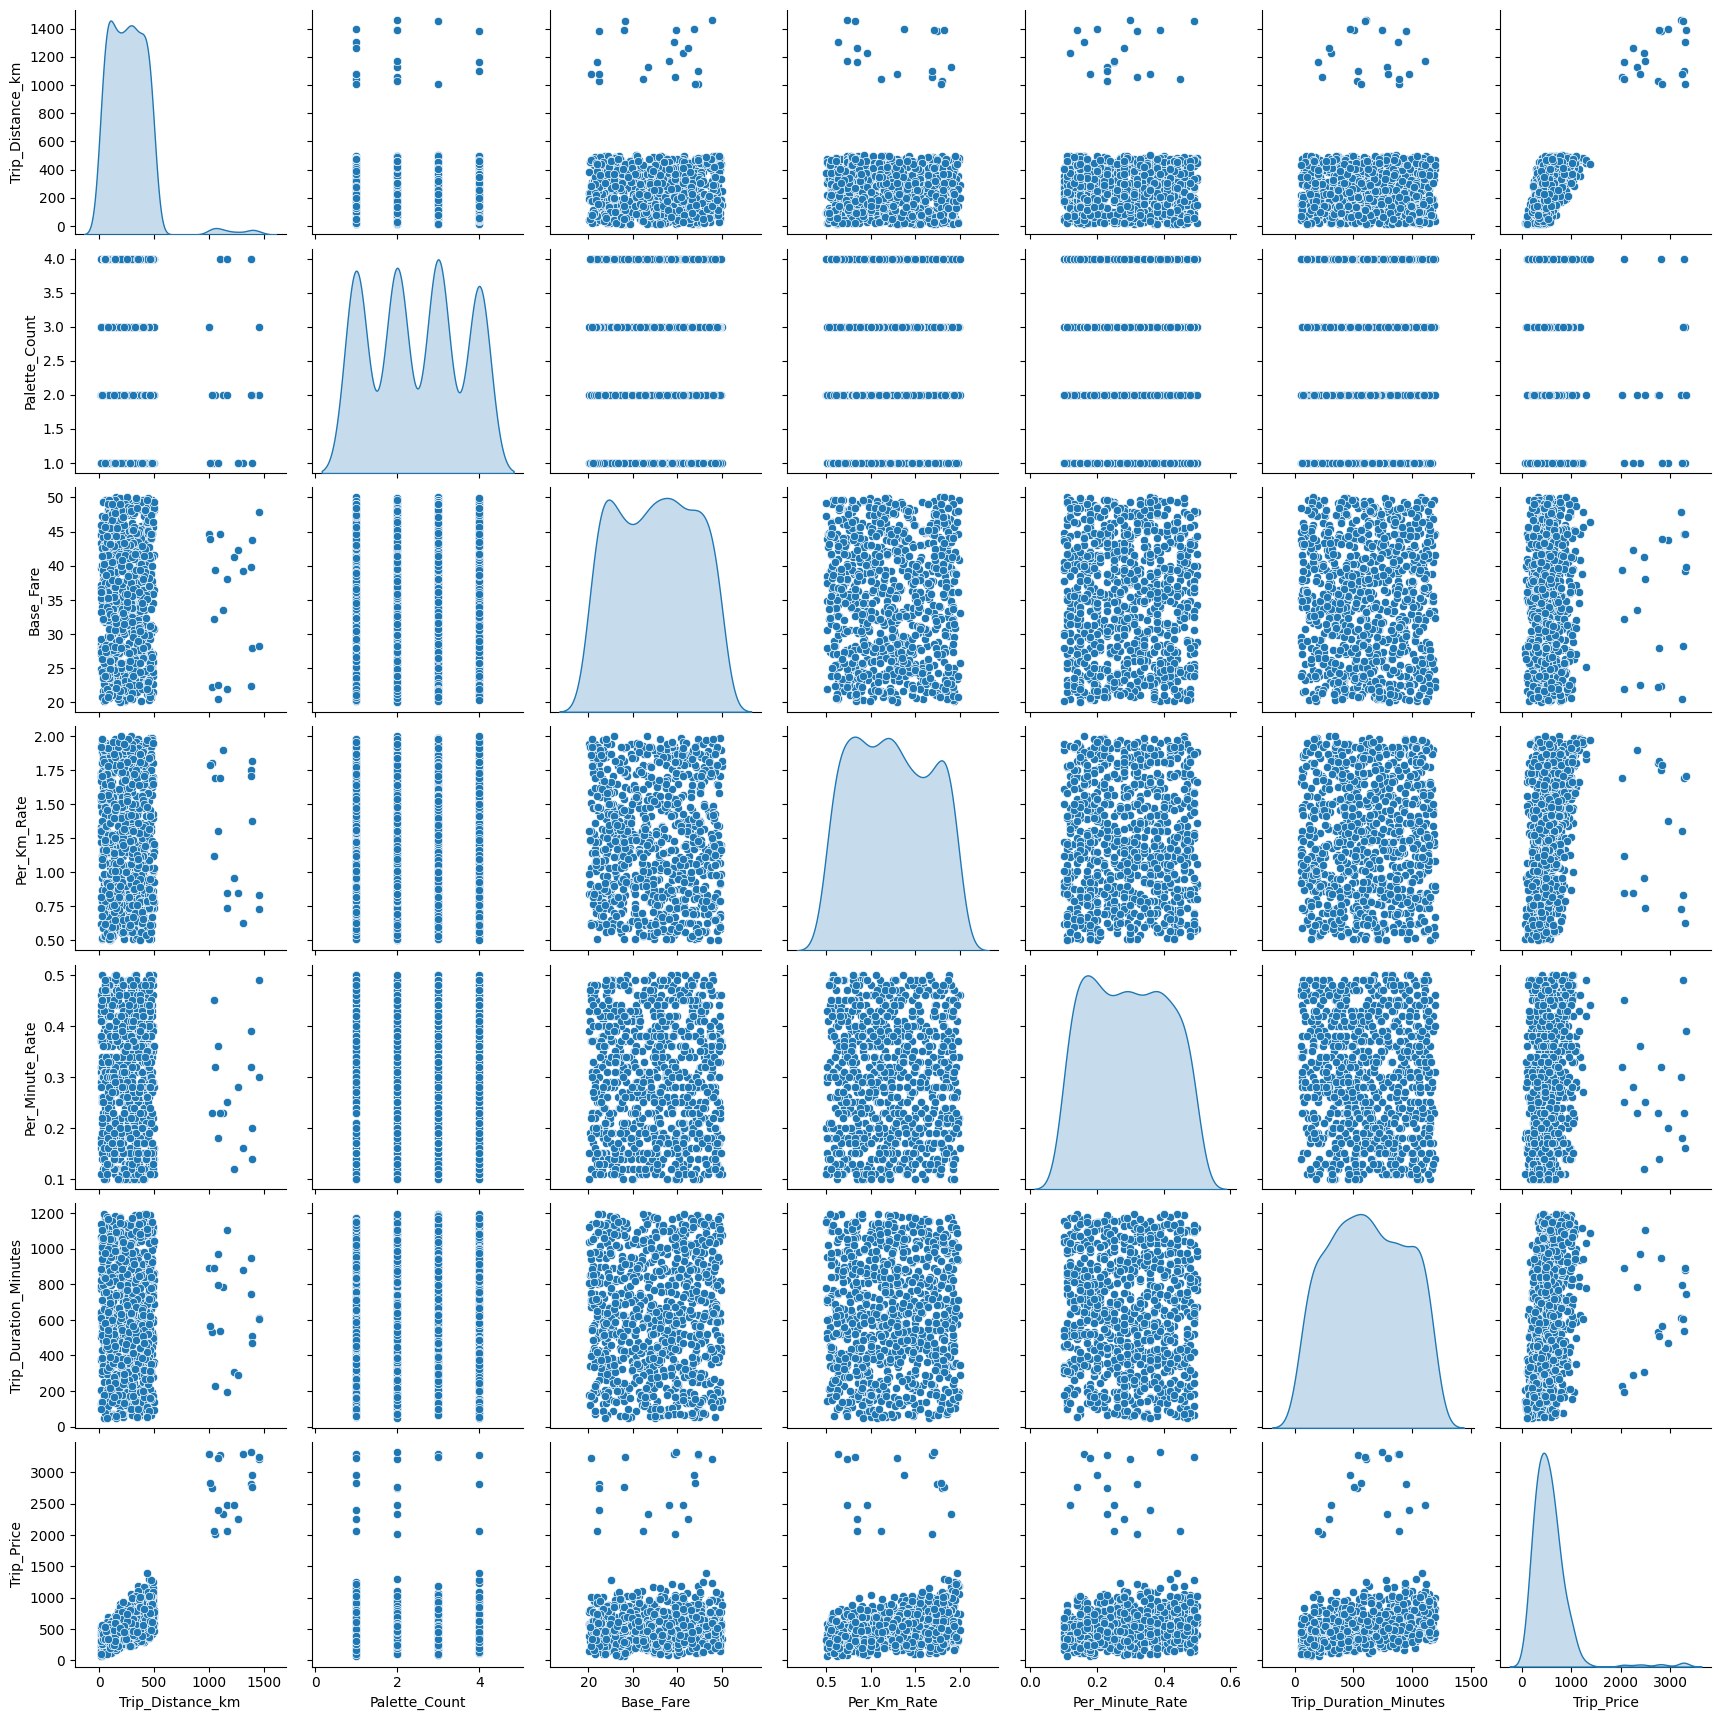

In [43]:
_ = sns.pairplot(df,diag_kind='kde')
#I couldn't see any Trend Here in the data But this is too early to tell

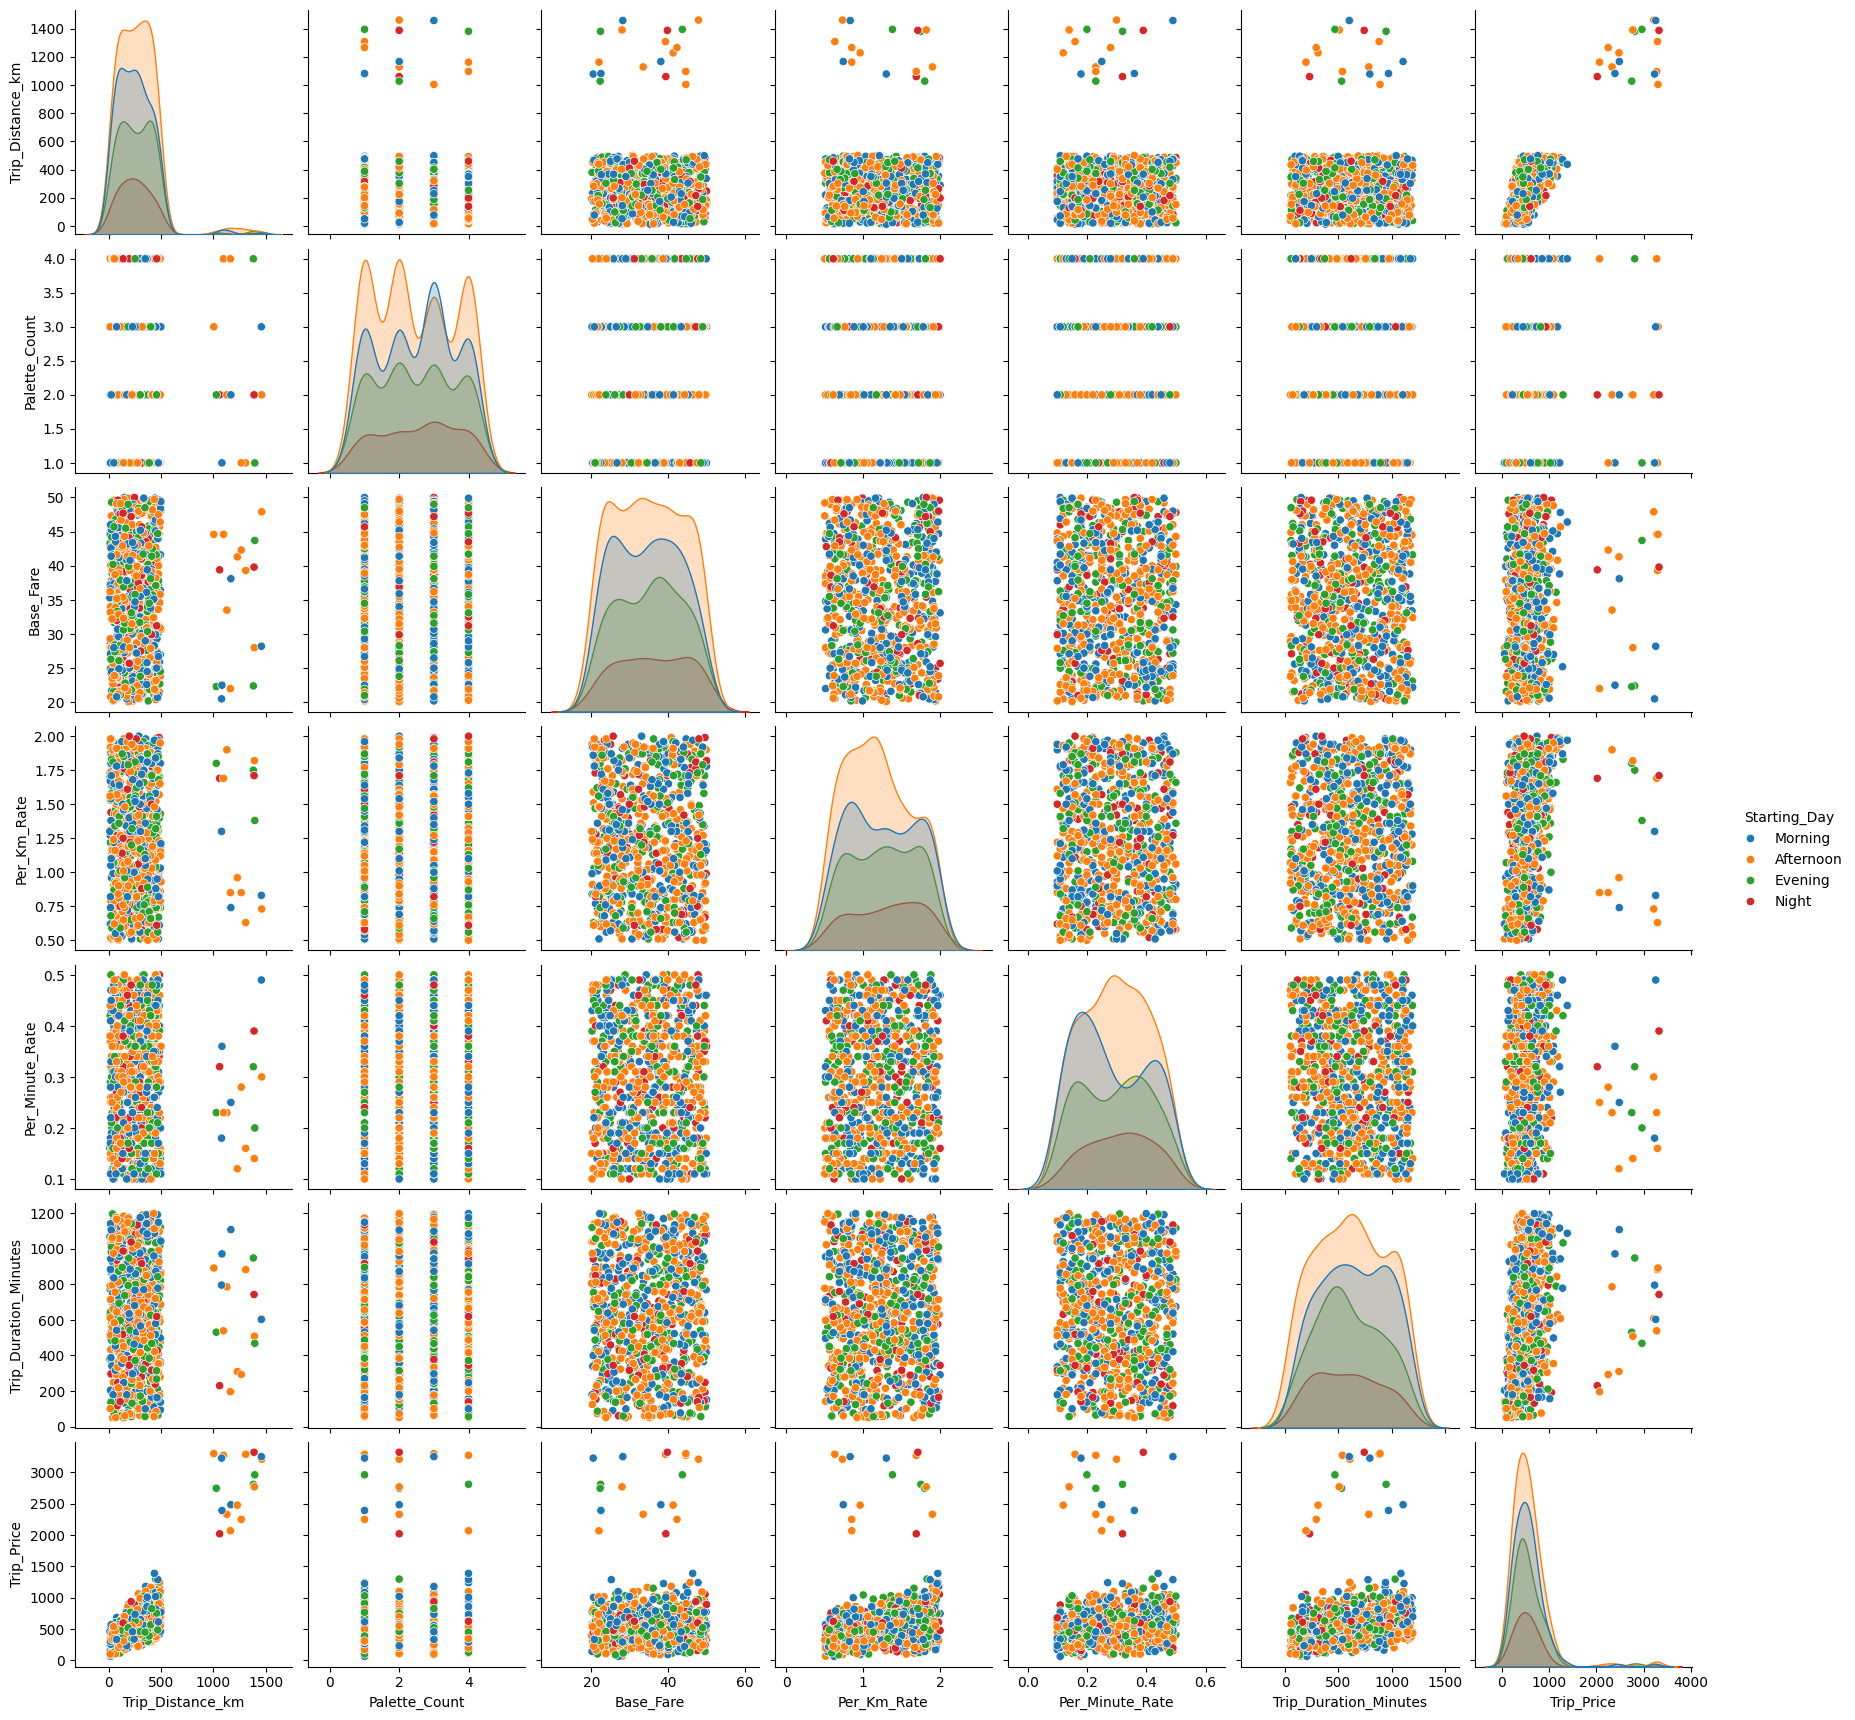

In [44]:
_ = sns.pairplot(df,diag_kind='kde',hue="Starting_Day")
#No luck on Starting day

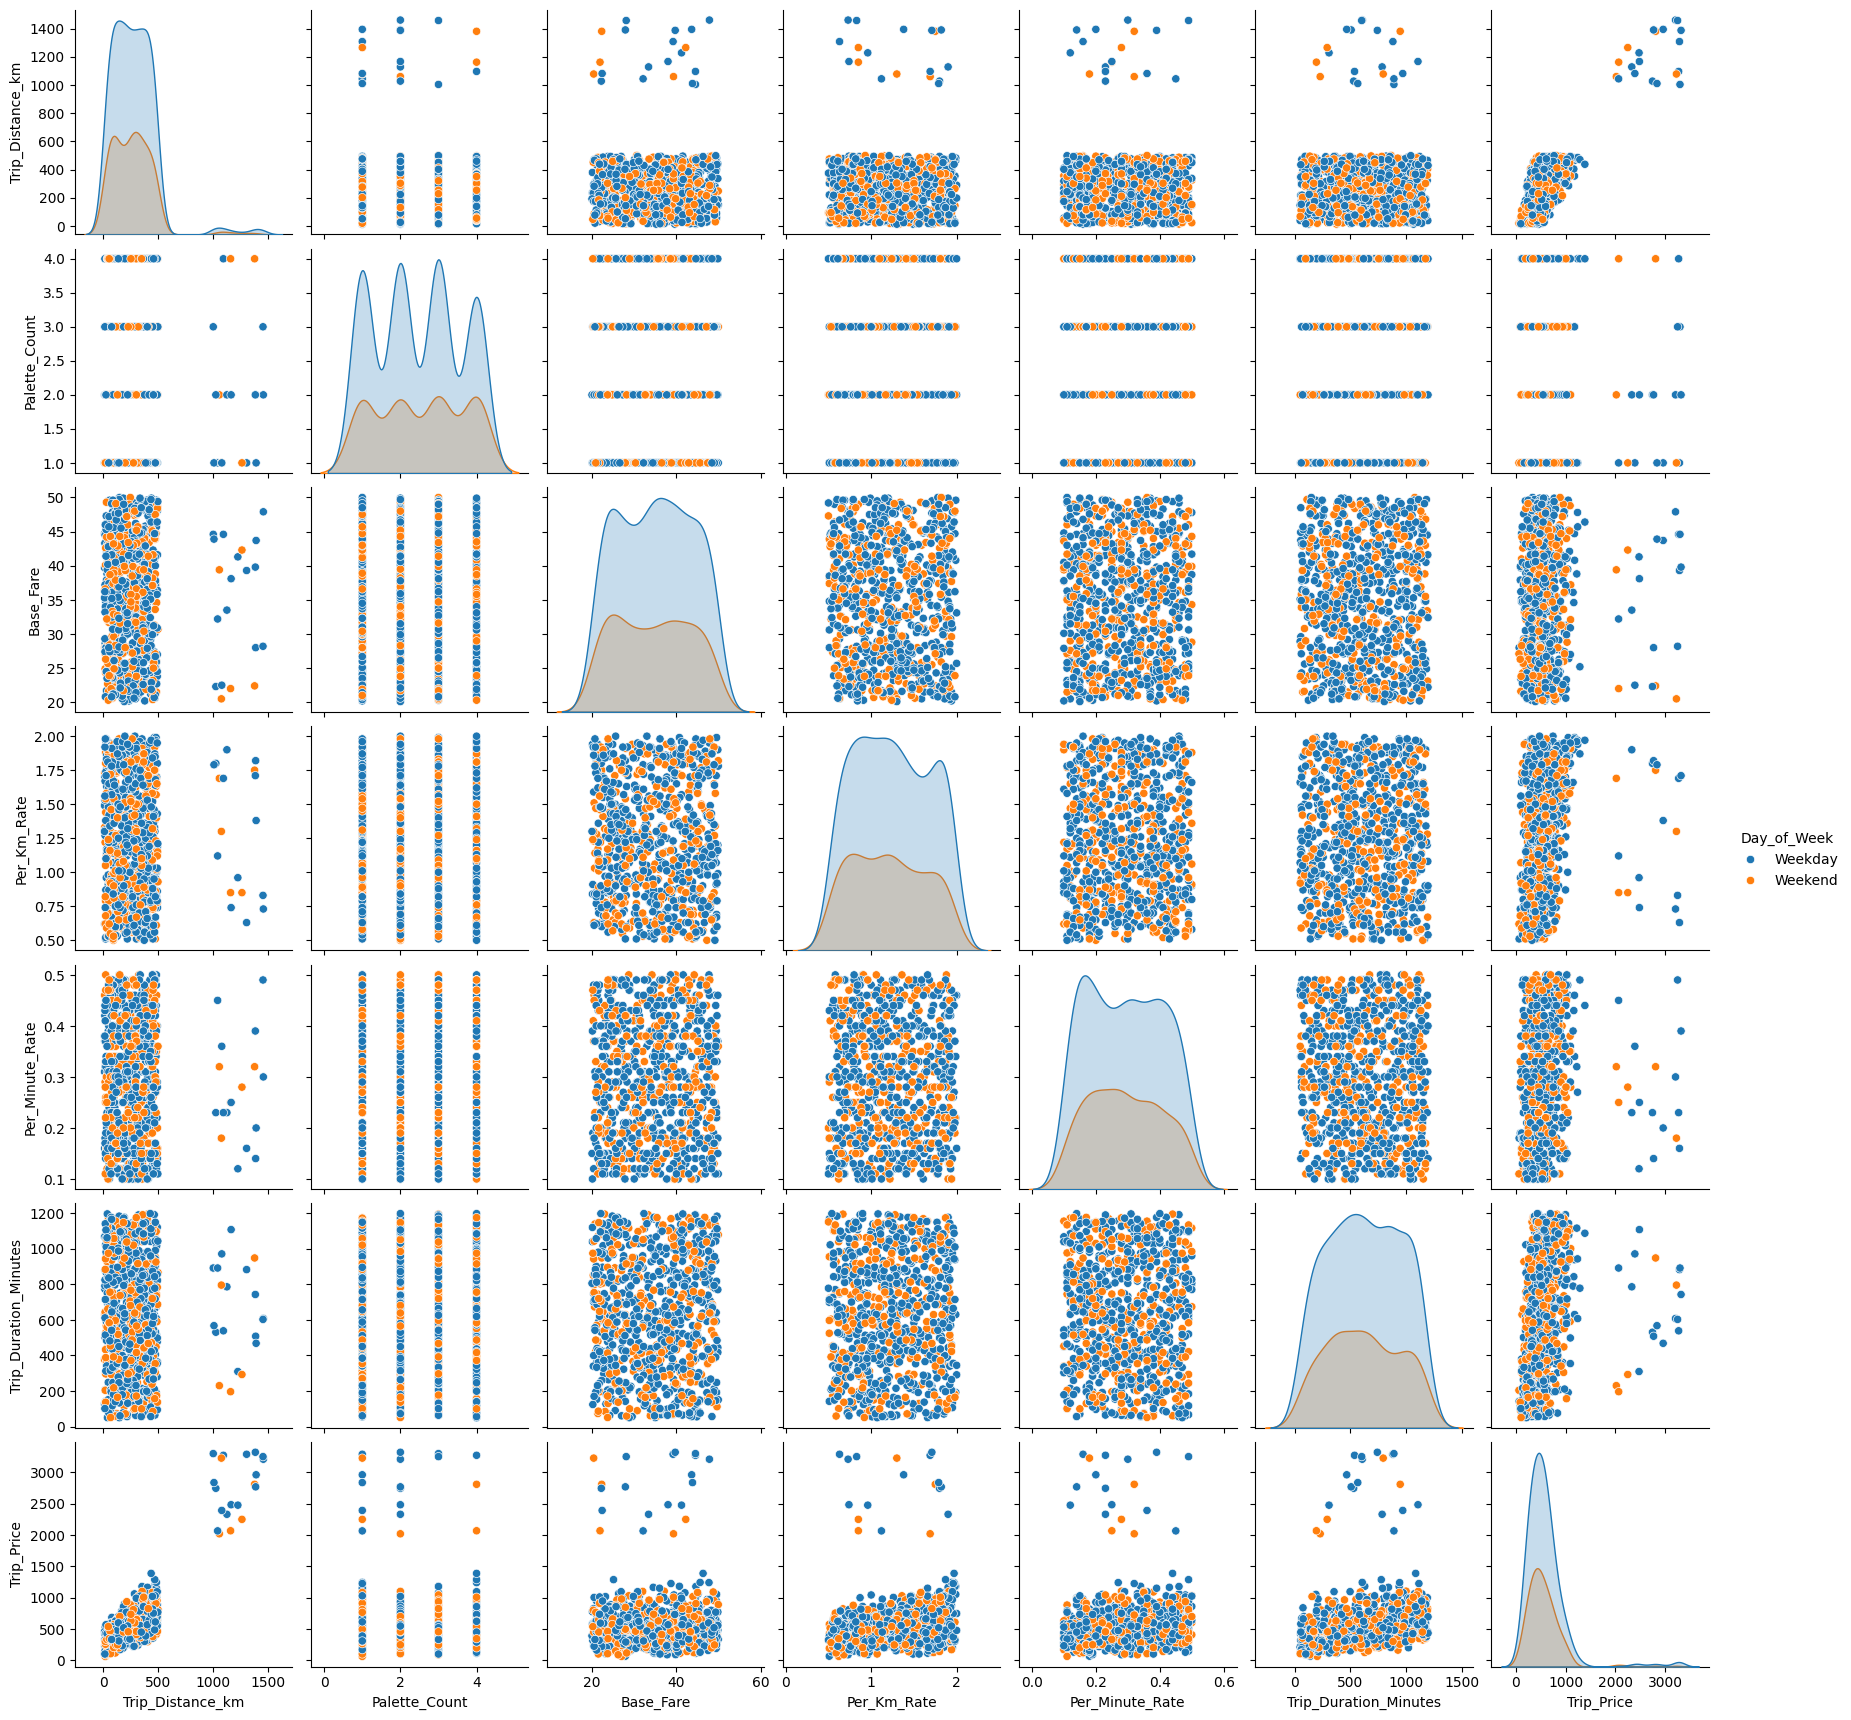

In [45]:
_ = sns.pairplot(df,diag_kind='kde',hue="Day_of_Week")
#No luck on Day_of_Week

In [46]:
"""This data Dosent any tend / Very few trend  with Targer Variable except Trip Distance Km Column . 
If i think on Regression Based i should say There are less variable which can Explain the Price"""

'This data Dosent any tend / Very few trend  with Targer Variable except Trip Distance Km Column . \nIf i think on Regression Based i should say There are less variable which can Explain the Price'

### Lets Try to Fill the Missing Value and See

In [47]:
#Keep in mind I am Not changing the Distribution Much By Adding Values in Median . Playing safe .
#But this I can do only With Continuous Column 

#### Median Imputation

In [48]:
columns_to_fill = ['Trip_Distance_km', 'Palette_Count', 'Base_Fare','Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].median())

In [49]:
df.isnull().sum()

Trip_Distance_km          0
Starting_Day             50
Day_of_Week              50
Palette_Count             0
Load_Count               50
Weather                  50
Base_Fare                 0
Per_Km_Rate               0
Per_Minute_Rate           0
Trip_Duration_Minutes     0
Trip_Price                0
dtype: int64

#### Mode Imputation

In [50]:
columns_to_fill1 = ['Starting_Day','Day_of_Week','Load_Count','Weather']
df[columns_to_fill1] = df[columns_to_fill1].fillna(df[columns_to_fill1].mode().iloc[0])

#### How much Changes Happened 

In [51]:
df.describe()

Trip_Distance_km  Palette_Count    Base_Fare  Per_Km_Rate  \
count       1000.000000    1000.000000  1000.000000  1000.000000   
mean         270.085195       2.453000    35.038400     1.232650   
std          194.026610       1.079331     8.481147     0.418932   
min           12.300000       1.000000    20.100000     0.500000   
25%          131.075000       2.000000    27.700000     0.870000   
50%          258.300000       2.000000    35.200000     1.220000   
75%          377.825000       3.000000    42.025000     1.580000   
max         1460.670472       4.000000    50.000000     2.000000   

       Per_Minute_Rate  Trip_Duration_Minutes   Trip_Price  
count      1000.000000            1000.000000  1000.000000  
mean          0.292770             621.052100   565.415599  
std           0.112664             313.394637   394.921295  
min           0.100000              50.100000    61.269000  
25%           0.197500             371.075000   345.788500  
50%           0.290000             618.600000   500.745000  
75%           0.382500             877.750000   674.766500  
max           0.500000            1198.400000  3320.436887

In [52]:
df_backup.describe()

Trip_Distance_km  Palette_Count   Base_Fare  Per_Km_Rate  \
count        950.000000     950.000000  950.000000   950.000000   
mean         270.705469       2.476842   35.029895     1.233316   
std          199.052998       1.102249    8.701619     0.429816   
min           12.300000       1.000000   20.100000     0.500000   
25%          126.325000       1.250000   27.300000     0.860000   
50%          258.300000       2.000000   35.200000     1.220000   
75%          384.050000       3.000000   42.600000     1.610000   
max         1460.670472       4.000000   50.000000     2.000000   

       Per_Minute_Rate  Trip_Duration_Minutes   Trip_Price  
count       950.000000             950.000000   951.000000  
mean          0.292916             621.181158   568.747733  
std           0.115592             321.544065   404.697906  
min           0.100000              50.100000    61.269000  
25%           0.190000             358.825000   337.426500  
50%           0.290000             618.600000   500.745000  
75%           0.390000             890.550000   690.993500  
max           0.500000            1198.400000  3320.436887

### What Difference in Corr i could see ?

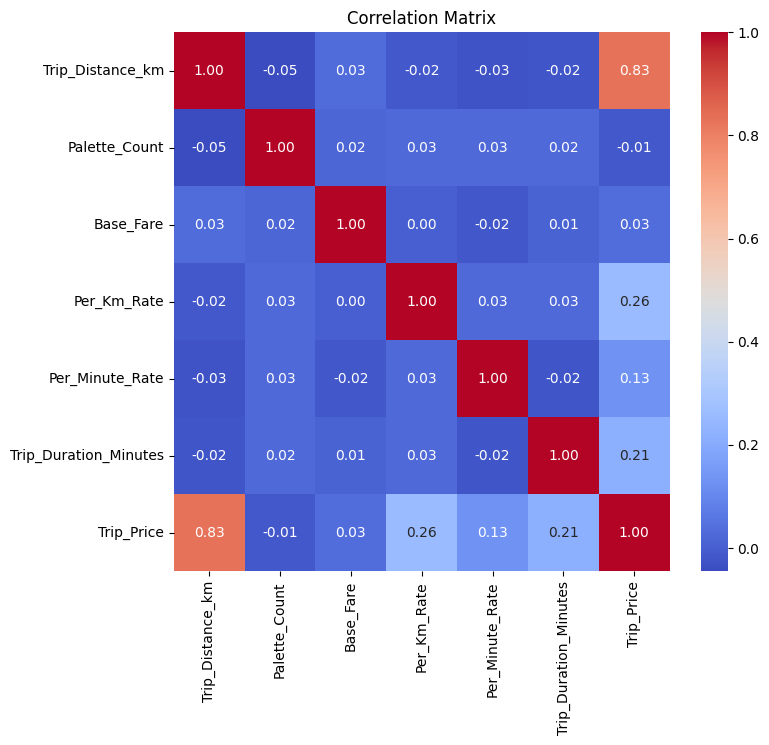

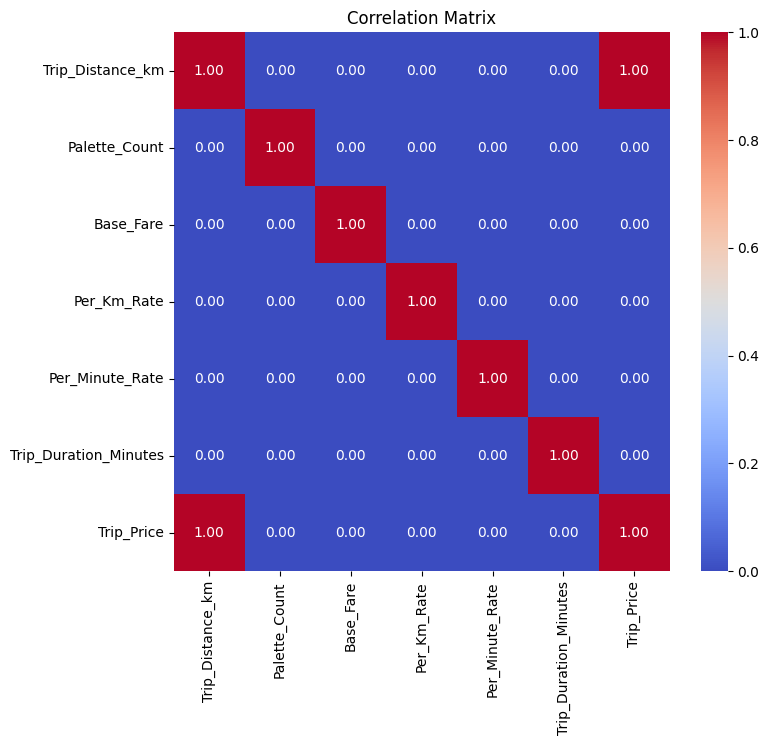

In [53]:
numeric_df = df.select_dtypes(include=['number'])
corre = numeric_df.corr()

_ = plt.figure(figsize=(8, 7))
_ = sns.heatmap(corre, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
_ = plt.title('Correlation Matrix')
_ = plt.show()

_ = plt.figure(figsize=(8, 7))
_ = sns.heatmap(corre.abs() > 0.5, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
_ = plt.title('Correlation Matrix')
_ = plt.show()

### I need the Categorical column to be Computer understandable

In [54]:
#One Hot Encoding
df = pd.get_dummies(df, columns = ['Starting_Day','Day_of_Week', 'Load_Count', 'Weather'], drop_first=True)

### All we did will Come to Result when we do our modeling . But Yes its too early , We can Do more Creativity also !!!

In [55]:
from IPython.display import display, HTML

url = "https://s.yimg.com/ny/api/res/1.2/NbhyugwyTRHQxPqWO9scqQ--/YXBwaWQ9aGlnaGxhbmRlcjt3PTEyNDI7aD0xMjQy/https://media.zenfs.com/en/aol_bored_panda_979/f4dd9b7818e29b1a8a9aafb2a2e6a95e"
display(HTML(f'<a href="{url}" target="_blank" style="font-size:20px; font-weight:bold;">Do not Click on this Link if You feeling Sleepy</a>'))


In [56]:
# Identify What is X and What is Y .BE carefull Here
X = df.drop(['Trip_Price'], axis=1)
y = df['Trip_Price']
features = X.columns

In [57]:
numeric_columns = ['Trip_Distance_km', 'Palette_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[numeric_columns] = scaler.fit_transform(X[numeric_columns])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20, random_state=42) 
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

In [59]:
from tqdm import tqdm

In [60]:

param_xgb = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.2],  
    'max_depth': [5, 10],
    'subsample': [0.8, 1.0],
    'min_child_weight': [ 3, 5]    
}

param_combinations = list(ParameterGrid(param_xgb))
pbar = tqdm(total=len(param_combinations) * 5)  # Multiply by CV folds

grid_search_xgb = GridSearchCV(xgb_regressor, param_xgb, cv=5, verbose=0)

for _ in param_combinations:
    grid_search_xgb.fit(X_train, y_train)
    pbar.update(5)  # Update progress for each CV fold

pbar.close()
best_gs_xgb = grid_search_xgb.best_estimator_

  0%|                                                                                                                | 0/80 [00:00<?, ?it/s]

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

  6%|██████▌                                                                                                 | 5/80 [00:07<01:47,  1.43s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 12%|████████████▉                                                                                          | 10/80 [00:15<01:51,  1.59s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 19%|███████████████████▎                                                                                   | 15/80 [00:23<01:39,  1.54s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 25%|█████████████████████████▊                                                                             | 20/80 [00:30<01:31,  1.53s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 31%|████████████████████████████████▏                                                                      | 25/80 [00:39<01:30,  1.65s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 38%|██████████████████████████████████████▋                                                                | 30/80 [00:46<01:18,  1.57s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 44%|█████████████████████████████████████████████                                                          | 35/80 [00:53<01:06,  1.48s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 50%|███████████████████████████████████████████████████▌                                                   | 40/80 [01:00<00:58,  1.46s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 56%|█████████████████████████████████████████████████████████▉                                             | 45/80 [01:09<00:55,  1.59s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 62%|████████████████████████████████████████████████████████████████▍                                      | 50/80 [01:16<00:45,  1.53s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 69%|██████████████████████████████████████████████████████████████████████▊                                | 55/80 [01:26<00:40,  1.64s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 60/80 [01:37<00:36,  1.83s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 65/80 [01:45<00:25,  1.73s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 70/80 [01:55<00:18,  1.83s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75/80 [02:03<00:08,  1.79s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [02:11<00:00,  1.68s/it]

True

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [02:11<00:00,  1.64s/it]


In [61]:
print(" hello ")

 hello 


### Final Prediction

In [62]:
train_score = round(best_gs_xgb.score(X_train,y_train),4)
test_score = round(best_gs_xgb.score(X_test,y_test),4)
print(best_gs_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [63]:
print (f"Train_score, Test_score is {train_score *100, test_score * 100}")

Train_score, Test_score is (99.42999999999999, 93.01)


### Now I have the Best Mondel . Lets Agree on This  For now

In [64]:
import joblib

In [65]:
# Save the trained model and scaler
joblib.dump(best_gs_xgb, "xgb_model_V1.pkl")
joblib.dump(scaler, "scaler_V1.pkl")
# joblib.dump(feature_names, "feature_names.pkl")

['xgb_model_V1.pkl']

['scaler_V1.pkl']

### Now Let's modularize the code

In [ ]:
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV , ParameterGrid

# Data Preprocessor Class
class DataPreprocessor:
    def __init__(self, df):
        self.df = df.copy()
    
    def fill_missing_values(self):
        numeric_columns = ['Trip_Distance_km', 'Palette_Count', 'Base_Fare', 'Per_Km_Rate', 
                           'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']
        categorical_columns = ['Starting_Day', 'Day_of_Week', 'Load_Count', 'Weather']
        
        self.df[numeric_columns] = self.df[numeric_columns].fillna(self.df[numeric_columns].median())
        self.df[categorical_columns] = self.df[categorical_columns].fillna(self.df[categorical_columns].mode().iloc[0])
    
    def one_hot_encode(self):
        categorical_columns = ['Starting_Day', 'Day_of_Week', 'Load_Count', 'Weather']
        self.df = pd.get_dummies(self.df, columns=categorical_columns, drop_first=True)
    
    def preprocess(self):
        self.fill_missing_values()
        self.one_hot_encode()
        return self.df

# Model Training Class
class ModelTrainer:
    def __init__(self, df):
        self.df = df
        self.X = self.df.drop(columns=['Trip_Price'])
        self.y = self.df['Trip_Price']
        self.scaler = RobustScaler()
        self.model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    
    def prepare_data(self):
        numeric_columns = ['Trip_Distance_km', 'Palette_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
        self.X[numeric_columns] = self.scaler.fit_transform(self.X[numeric_columns])
        return train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    def train_model(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        param_grid = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [5], 
                      'subsample': [0.8], 'min_child_weight': [1]}
        
        grid_search = GridSearchCV(self.model, param_grid, cv=3, n_jobs=-1, error_score='raise')
        grid_search.fit(X_train, y_train)
        
        return grid_search.best_estimator_, self.scaler, X_train.columns

if __name__ == "__main__":
    df = pd.read_csv("Truck_price_prediction.csv")
    preprocessor = DataPreprocessor(df)
    df_cleaned = preprocessor.preprocess()
    
    trainer = ModelTrainer(df_cleaned)
    model, scaler, feature_names = trainer.train_model()

    # Save the trained model and scaler
    joblib.dump(model, "Model_objects/xgb_model.pkl")
    joblib.dump(scaler, "Model_objects/scaler.pkl")
    joblib.dump(feature_names, "Model_objects/feature_names.pkl")

    print("Model training complete. Files saved.")
